## Imports y data load

In [1]:
# Standard library
import os
from datetime import datetime
from imblearn.pipeline import Pipeline
from pathlib import Path
import sys

# Data & Numerical
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import optuna
from scipy.stats import uniform, randint

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, f1_score, make_scorer, 
    precision_score, recall_score, roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Imbalanced-learn
from imblearn.over_sampling import SMOTE

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb


c:\Users\Guada\Desktop\AA\aprendizaje_automatico_desertores\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Add parent directory to path
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))

# Custom imports
from scripts.results_analyzer_multiclase import ResultsAnalyzerMulticlase

In [3]:
df_int_multiclase = pd.read_csv('../data/base_procesada_multiclase.csv')

In [ ]:
# MUESTREO:
# df_int_multiclase = (
#     df_int_multiclase
#     .groupby('target_multiclase', group_keys=False)
#     .apply(lambda x: x.sample(frac=0.3, random_state=42))
# )

In [5]:
X = df_int_multiclase.drop(columns=['target_multiclase'])
y = df_int_multiclase['target_multiclase']

In [6]:
#Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [7]:
analyzer = ResultsAnalyzerMulticlase()

# Modelo multiclase

## KNN

In [8]:
# Se escalan los datos y se hace una búsqueda de hiperparámetros con gris search, buscando el k número de vecinos óptimo.
# Evalúa la clasificación con f1_weighted. weighted se usa a lo largo de toda la medición porque evita que las clases minoritarias sean ignoradas en la métrica global.
# Calcula el F1 por clase y hace promedio ponderado por la cantidad de ejemplos de cada clase. 
# Así las clases grandes pesan más, pero las pequeñas también cuentan.

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': range(3, 21),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  
    scoring='f1_weighted',
    n_jobs=-1,  
    verbose=1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits



RESULTADOS EN TEST SET - KNN
Accuracy:  0.7479
Precision weighted: 0.7349
Recall weighted:    0.7479
F1-Score weighted:  0.7287
ROC-AUC multiclase ponderada:   0.8643

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      2142
           1       0.57      0.54      0.55       845
           2       0.68      0.30      0.41       464

    accuracy                           0.75      3451
   macro avg       0.69      0.59      0.61      3451
weighted avg       0.73      0.75      0.73      3451



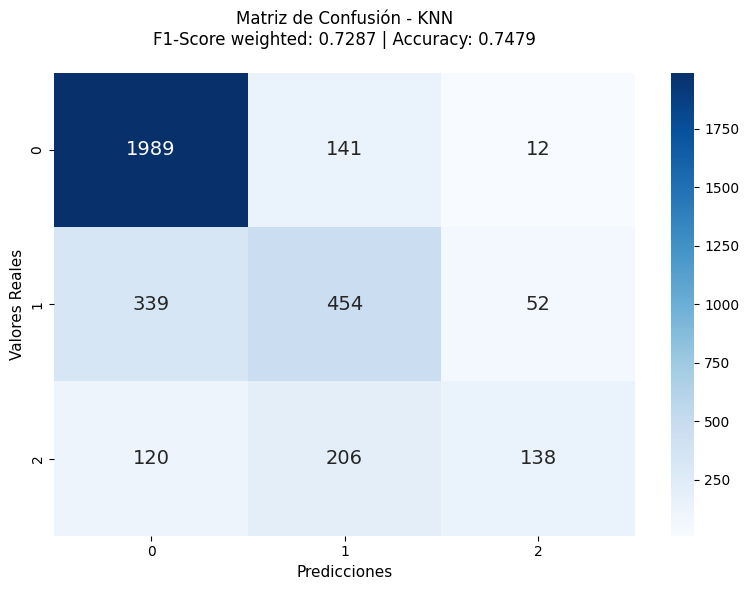

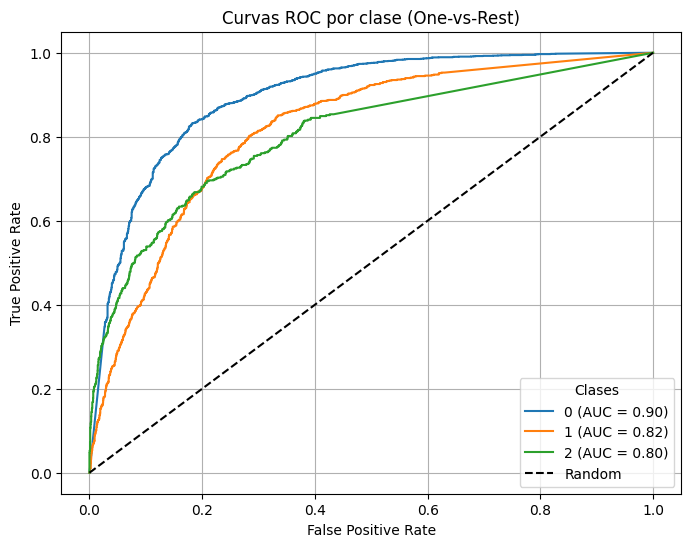

In [ ]:
results_df = analyzer.evaluar_y_guardar_modelo(grid_search, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="KNN multiclase")

In [ ]:
results_df.head()

,Modelo,Hiperparametros,Accuracy,F1_Score weighted,Precision weighted,Recall weighted,ROC-AUC multiclase ponderada,CV_F1_weighted_Mean,CV_F1_weighted_Std,Fecha
0,KNN,"{'classifier__metric': 'euclidean', 'classifie...",0.7479,0.7287,0.7349,0.7479,0.8643,0.7373,0.0055,2025-10-17 00:16:06


## Random Forest

In [13]:
# Pipeline para Random Forest
pipeline_rf = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parámetros para GridSearch
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': ['balanced', None]
}

grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)


# Usar mejor modelo
best_model = grid_search_rf.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits



RESULTADOS EN TEST SET - RANDOM FOREST
Accuracy:  0.7850
Precision weighted: 0.7770
Recall weighted:    0.7850
F1-Score weighted:  0.7781
ROC-AUC multiclase ponderada:   0.8987

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      2142
           1       0.62      0.63      0.63       845
           2       0.64      0.45      0.53       464

    accuracy                           0.78      3451
   macro avg       0.71      0.67      0.68      3451
weighted avg       0.78      0.78      0.78      3451



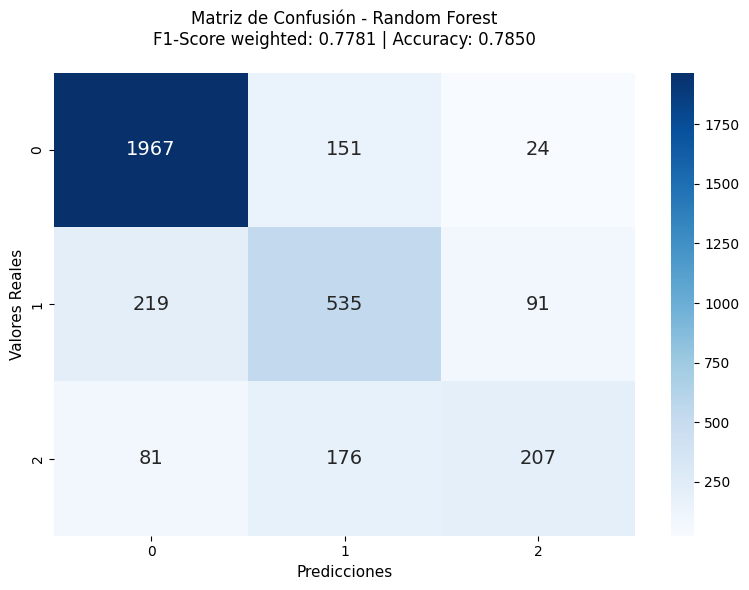

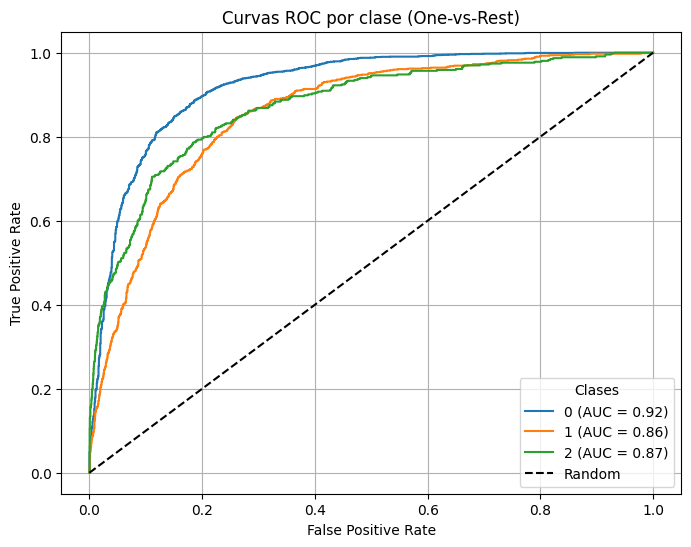

In [ ]:
results = analyzer.evaluar_y_guardar_modelo(grid_search_rf, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Random Forest multiclase")

In [15]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_multiclase.csv', index=False)

Pipeline detectado. Usando: RandomForestClassifier


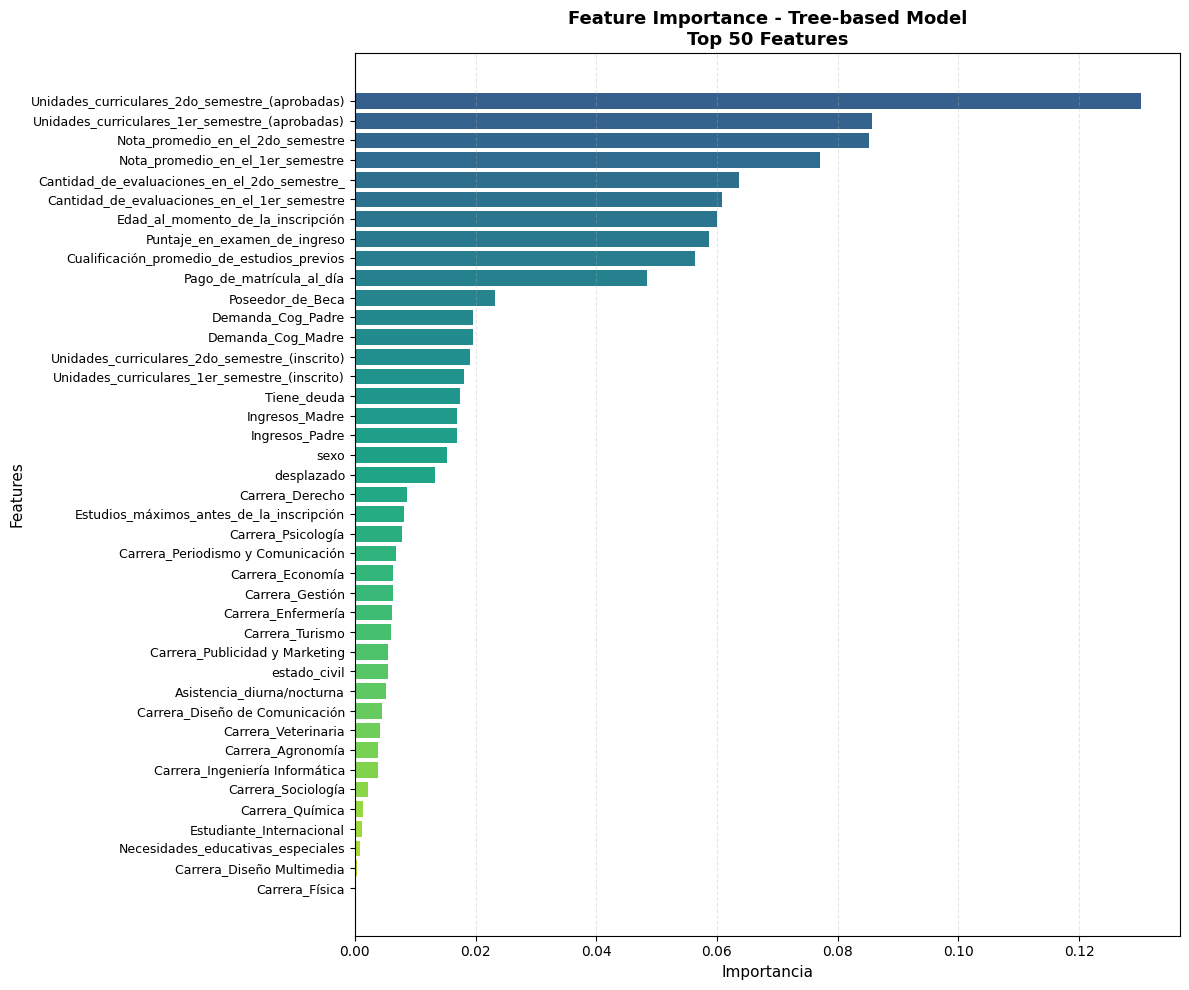


Top 41 Features:
                                       feature  importance
Unidades_curriculares_2do_semestre_(aprobadas)    0.130198
Unidades_curriculares_1er_semestre_(aprobadas)    0.085602
              Nota_promedio_en_el_2do_semestre    0.085185
              Nota_promedio_en_el_1er_semestre    0.077086
  Cantidad_de_evaluaciones_en_el_2do_semestre_    0.063587
   Cantidad_de_evaluaciones_en_el_1er_semestre    0.060888
             Edad_al_momento_de_la_inscripción    0.059942
                  Puntaje_en_examen_de_ingreso    0.058681
    Cualificación_promedio_de_estudios_previos    0.056349
                      Pago_de_matrícula_al_día    0.048465
                              Poseedor_de_Beca    0.023182
                             Demanda_Cog_Padre    0.019634
                             Demanda_Cog_Madre    0.019553
 Unidades_curriculares_2do_semestre_(inscrito)    0.019064
 Unidades_curriculares_1er_semestre_(inscrito)    0.018066
                                   Tie

In [16]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

##  Boosting y Bagging

### LightGBM

In [ ]:
pipeline = Pipeline([
    ('classifier', lgb.LGBMClassifier(
        objective='multiclass',
        random_state=42,
        verbose=-1,
        n_jobs=-1
    ))
])


param_grid = {
    'classifier__n_estimators': randint(100, 800),
    'classifier__max_depth': randint(3, 12),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__num_leaves': randint(20, 150),
    'classifier__min_child_samples': randint(10, 100),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__reg_alpha': uniform(0, 1),
    'classifier__reg_lambda': uniform(0, 1)
}

grid_search_gbm = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=50,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True 
)

grid_search_gbm.fit(X_train, y_train)
best_model = grid_search_gbm.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits



RESULTADOS EN TEST SET - BOOSTING LIGHTGBM MULTICLASE
Accuracy:  0.7838
Precision weighted: 0.7739
Recall weighted:    0.7838
F1-Score weighted:  0.7750
ROC-AUC multiclase ponderada:   0.9024

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      2142
           1       0.62      0.61      0.62       845
           2       0.67      0.45      0.54       464

    accuracy                           0.78      3451
   macro avg       0.72      0.66      0.68      3451
weighted avg       0.77      0.78      0.77      3451



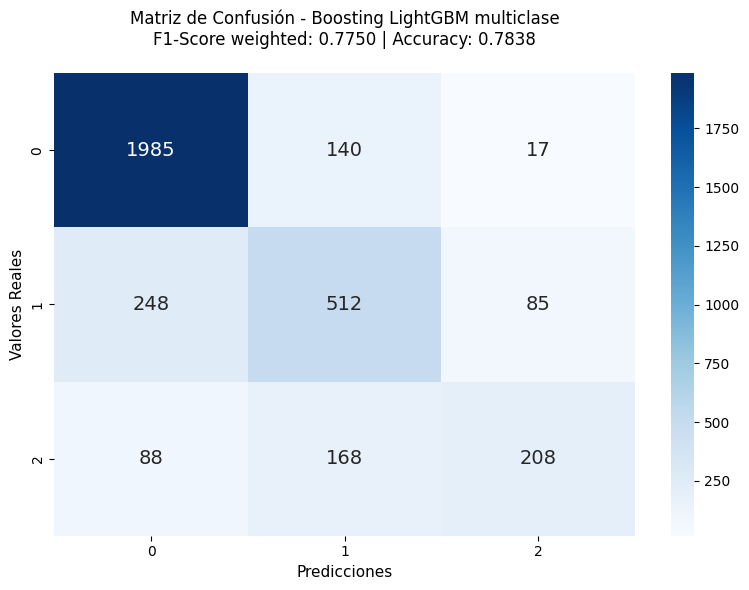

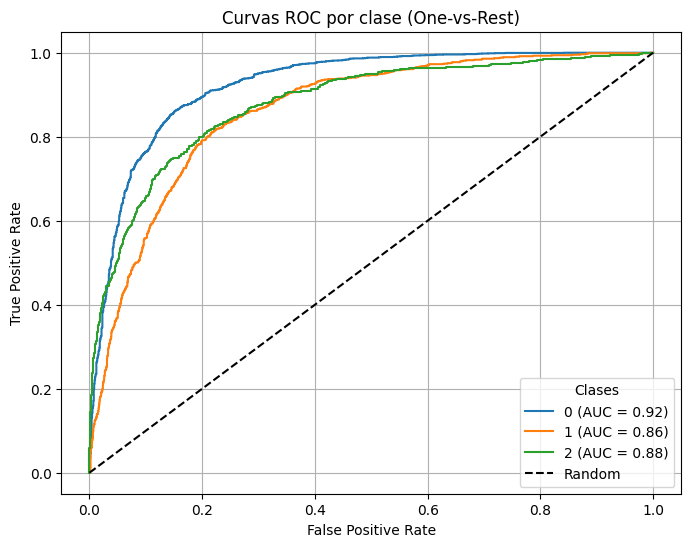

In [ ]:
results = analyzer.evaluar_y_guardar_modelo(grid_search_gbm, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Boosting LightGBM multiclase")

In [20]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_binaria.csv', index=False)

Pipeline detectado. Usando: LGBMClassifier


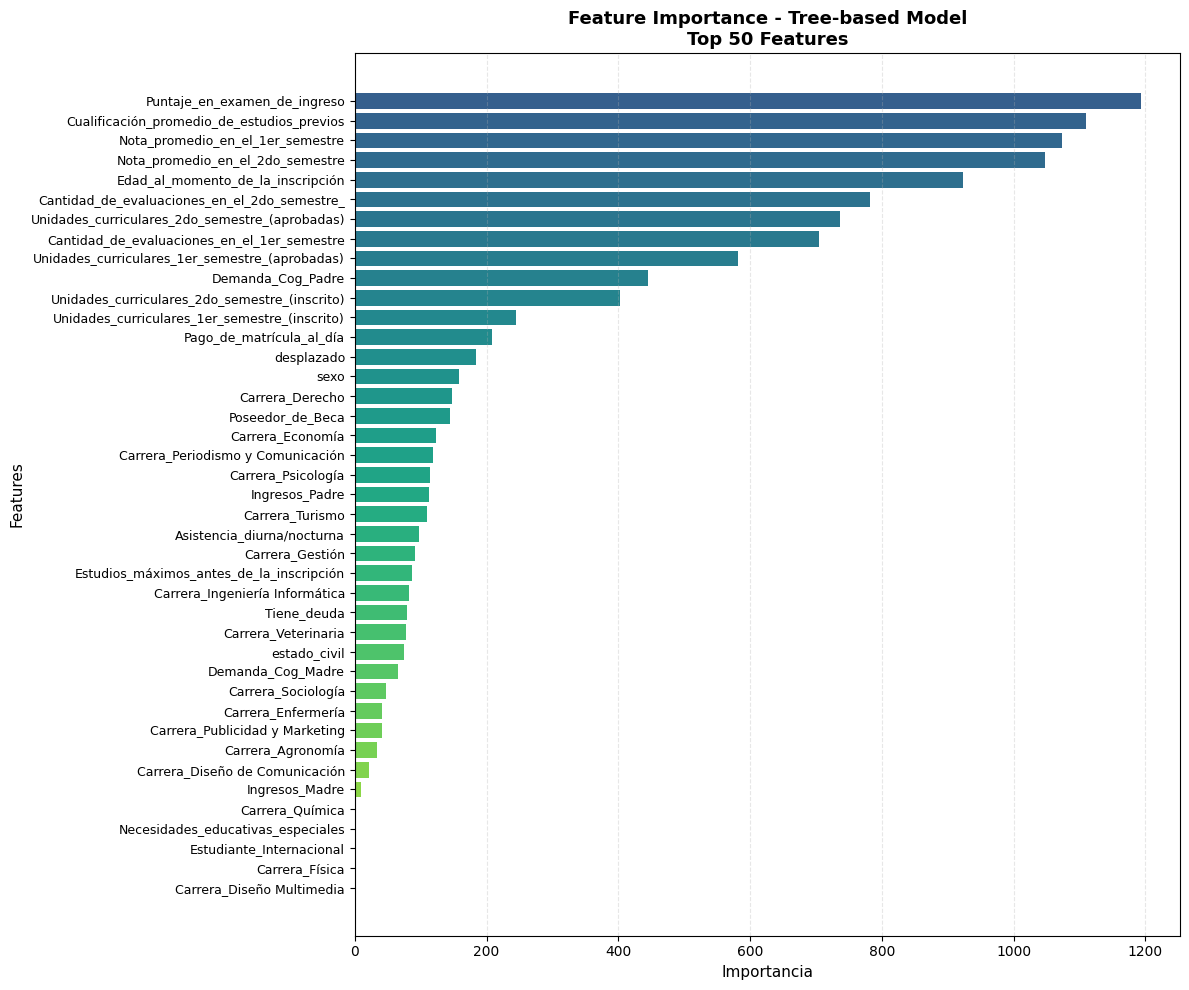


Top 41 Features:
                                       feature  importance
                  Puntaje_en_examen_de_ingreso        1193
    Cualificación_promedio_de_estudios_previos        1110
              Nota_promedio_en_el_1er_semestre        1074
              Nota_promedio_en_el_2do_semestre        1048
             Edad_al_momento_de_la_inscripción         924
  Cantidad_de_evaluaciones_en_el_2do_semestre_         782
Unidades_curriculares_2do_semestre_(aprobadas)         736
   Cantidad_de_evaluaciones_en_el_1er_semestre         705
Unidades_curriculares_1er_semestre_(aprobadas)         582
                             Demanda_Cog_Padre         445
 Unidades_curriculares_2do_semestre_(inscrito)         402
 Unidades_curriculares_1er_semestre_(inscrito)         244
                      Pago_de_matrícula_al_día         208
                                    desplazado         184
                                          sexo         158
                               Carrera

In [19]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))

### XGBoost

In [23]:
pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        verbose=-1,
        n_jobs=-1
    ))
])


param_grid = {
    'classifier__n_estimators': randint(100, 800),
    'classifier__max_depth': randint(3, 12),
    'classifier__learning_rate': uniform(0.01, 0.2),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
    'classifier__reg_alpha': uniform(0, 1),
    'classifier__reg_lambda': uniform(0, 1)
}

grid_search_xgb = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=50,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True 
)

grid_search_xgb.fit(X_train, y_train)
best_model = grid_search_xgb.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits



RESULTADOS EN TEST SET - BOOSTING XGBOOST MULTICLASE
Accuracy:  0.7867
Precision weighted: 0.7785
Recall weighted:    0.7867
F1-Score weighted:  0.7773
ROC-AUC multiclase ponderada:   0.9039

------------------------------------------------------------
REPORTE DE CLASIFICACIÓN:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      2142
           1       0.63      0.62      0.63       845
           2       0.71      0.44      0.54       464

    accuracy                           0.79      3451
   macro avg       0.73      0.66      0.68      3451
weighted avg       0.78      0.79      0.78      3451



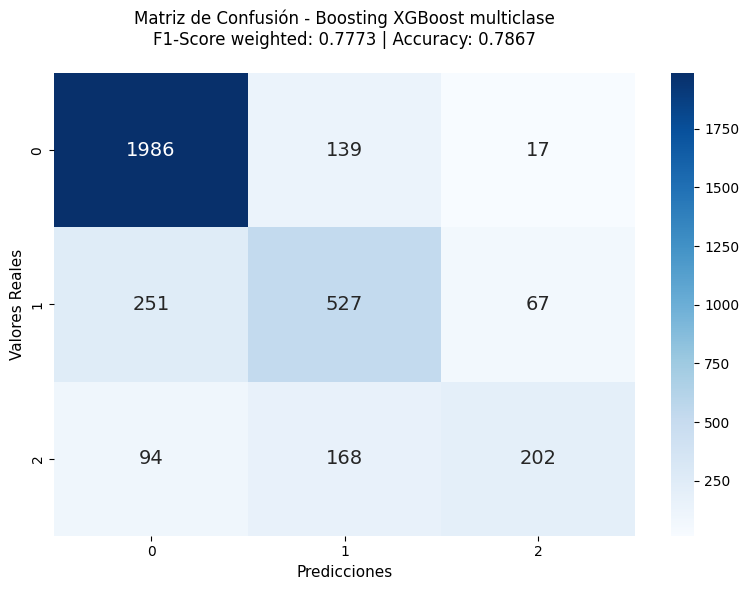

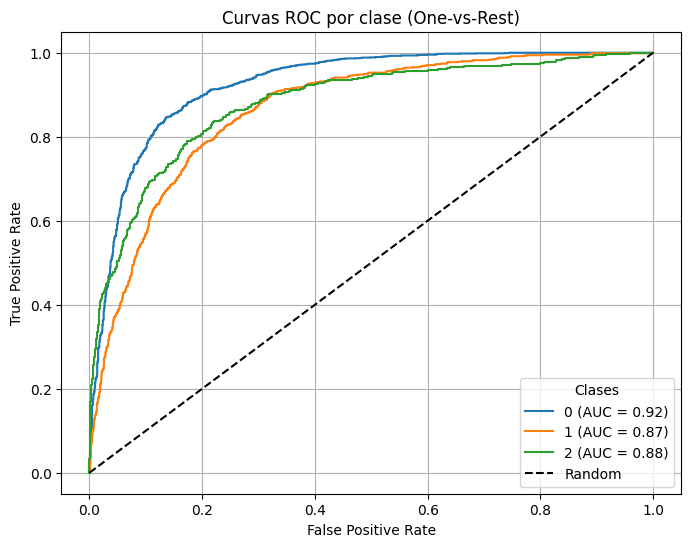

In [24]:
results = analyzer.evaluar_y_guardar_modelo(grid_search_xgb, X_test, y_test, y_pred, y_pred_proba,
                          nombre_modelo="Boosting XGBoost multiclase")

In [25]:
results_df = pd.concat([results_df, results], ignore_index=True)
results_df.to_csv('../results/resultados_modelos_binaria.csv', index=False)

Pipeline detectado. Usando: XGBClassifier


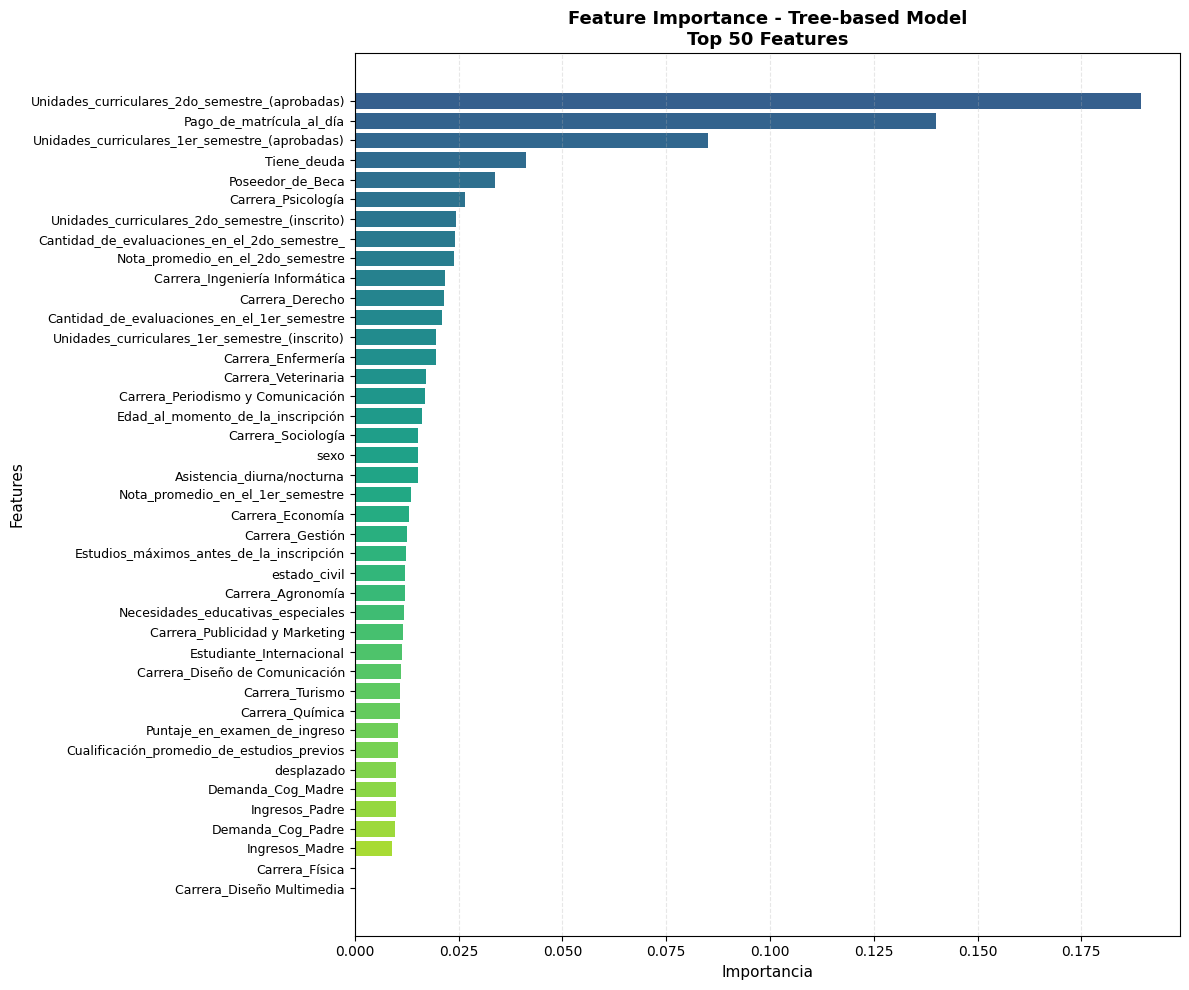


Top 41 Features:
                                       feature  importance
Unidades_curriculares_2do_semestre_(aprobadas)    0.189299
                      Pago_de_matrícula_al_día    0.139894
Unidades_curriculares_1er_semestre_(aprobadas)    0.084973
                                   Tiene_deuda    0.041354
                              Poseedor_de_Beca    0.033668
                            Carrera_Psicología    0.026536
 Unidades_curriculares_2do_semestre_(inscrito)    0.024333
  Cantidad_de_evaluaciones_en_el_2do_semestre_    0.024139
              Nota_promedio_en_el_2do_semestre    0.023852
                Carrera_Ingeniería Informática    0.021679
                               Carrera_Derecho    0.021518
   Cantidad_de_evaluaciones_en_el_1er_semestre    0.020919
 Unidades_curriculares_1er_semestre_(inscrito)    0.019571
                            Carrera_Enfermería    0.019507
                           Carrera_Veterinaria    0.017268
             Carrera_Periodismo y Comu

In [26]:
feature_importance_df = analyzer.plot_feature_importance(
    modelo=best_model,
    X_train=X_train,
    top_n=50,
    figsize=(12, 10))